**Author**: Andy Tzanidakis \
**Last updated**: May 15, 2024

## Overview

In this notebook we will learn how to use the outputs from LSDB catalogs and use `ensamble` from TAPE to compute time-series features.

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata
import tape
from tape import Ensemble, ColumnMapper

# Astropy
from astropy.timeseries import LombScargle

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')
print(f'Version of TAPE is {tape.__version__}')

Version of lsdb is 0.2.3
Version of TAPE is 0.4.1


## Initialize hipscat catalogs

In [2]:
%%time


# Gaia
gaia_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/gaia_dr3/gaia"

# ZTF
ztf_object_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_dr14/"
ztf_source_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_zource/"


# load Gaia object table
gaia = lsdb.read_hipscat(gaia_path, columns=['ra', 'dec', 'parallax'])
# load ZTF object table
ztf = lsdb.read_hipscat(ztf_object_path, columns=['ra', 'dec', 'ps1_objid'])
# load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat(ztf_source_path, columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'])

CPU times: user 1.42 s, sys: 147 ms, total: 1.57 s
Wall time: 3.65 s


## Cone Search 

In [3]:
%%time

# TODO: rename rad to be more descriptive
# TODO: remove magical value of 3 below and replace with a variable

# Cone search around a given position
ra, dec = 132.8460000, +11.8140000
rad = 5_000  # in arcsec

_sample = ztf.cone_search(ra=ra,
    dec=dec,
    radius_arcsec=rad).crossmatch(gaia, radius_arcsec=3).compute()

/opt/miniconda3/envs/tape/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


CPU times: user 1.91 s, sys: 1.18 s, total: 3.09 s
Wall time: 14.5 s


In [4]:
_sample

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_hipscat_index,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
1195635245353795584,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445
1195681424221405184,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
1195681461315829760,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [5]:
print (f"Number of objects in crossmatch: {len(_sample)}")

Number of objects in crossmatch: 36717


In [6]:
%%time
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    ra_column="ra_ztf_dr14", 
    dec_column="dec_ztf_dr14", 
    lowest_order=5
)

CPU times: user 9.72 s, sys: 17.3 ms, total: 9.74 s
Wall time: 9.81 s


In [7]:
_sample_hips

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,Norder,Dir,Npix
npartitions=6,,,,,,,,,,
1194579801160024064,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1196831600973709312,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
1215971899390033920,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...


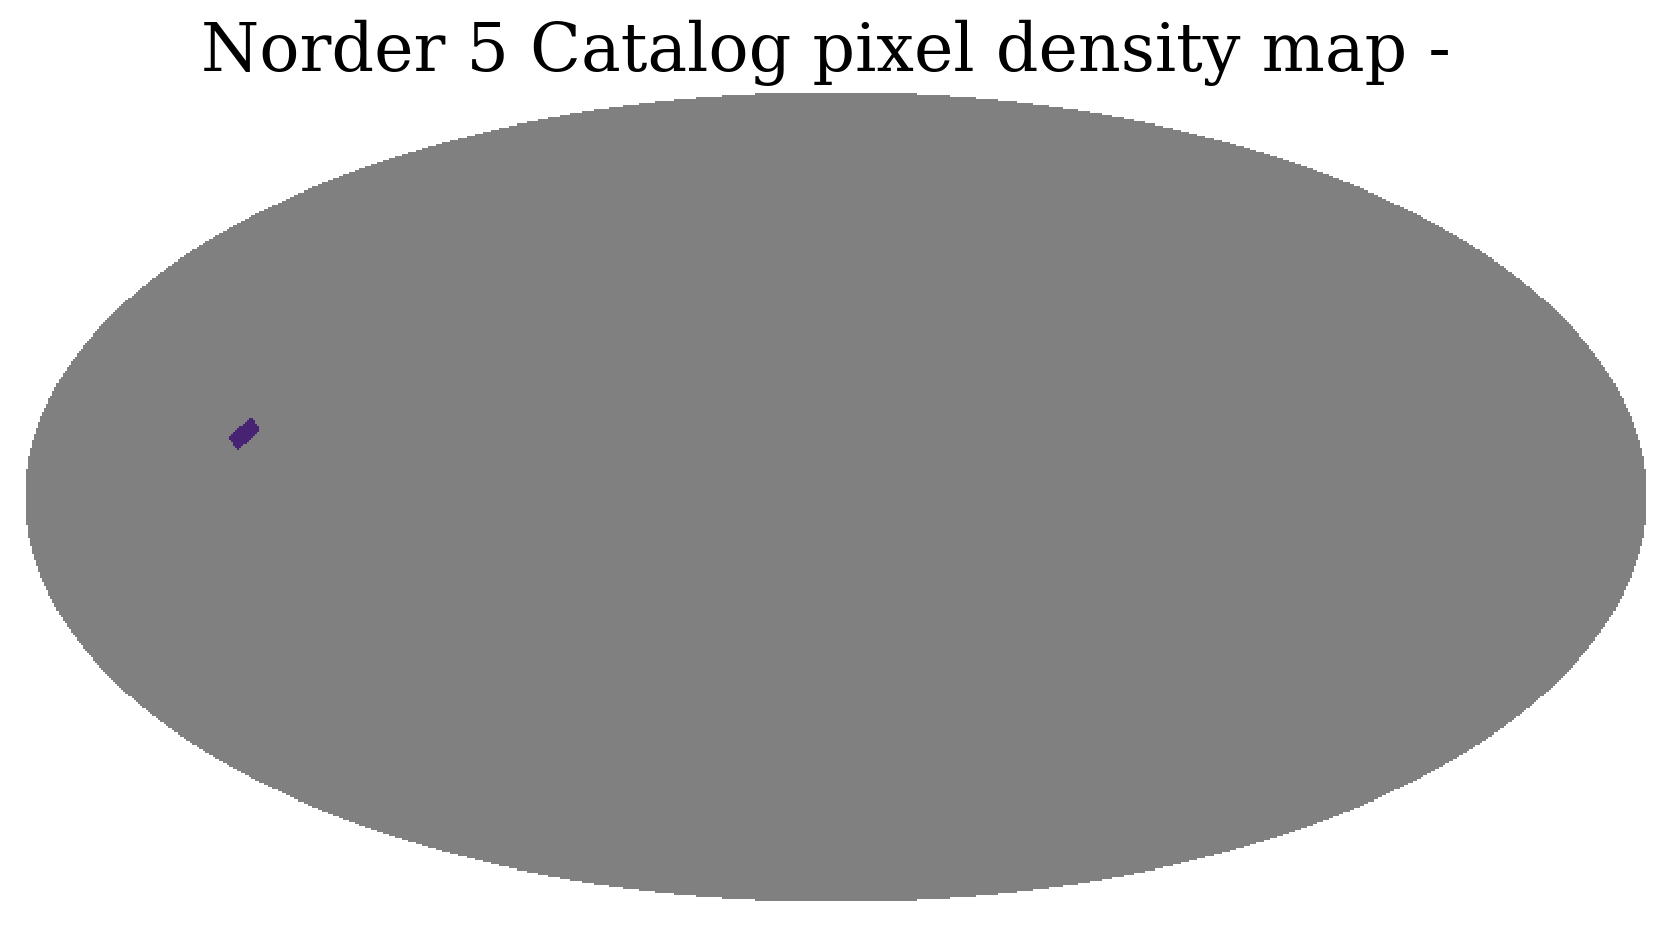

In [8]:
# TODO: explain why this is so empty

plot_pixels(_sample_hips.hc_structure)

### Join sample hips with ZTF sources 

In [9]:
# Peform a join between the crossmatch and the ZTF sources using the PS1 object ID
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/opt/miniconda3/envs/tape/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:196: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [10]:
len(ss.columns)

18

### Initialize Dask Client

In [11]:
# Initialize dask client with 2 workers
# We initialize with 12 GiB of memory and 1 thread per worker, so that we sure we do not overload 
# the memory resources of the machine
from dask.distributed import Client
client = Client(n_workers=2, memory_limit="12GiB", threads_per_worker=1)

## Initialize TAPE `ens`

In [12]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble - pass the dask client to the ensemble
ens = Ensemble(client=client)

In [13]:
ens.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54991,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:54998,Total threads: 1
Dashboard: http://127.0.0.1:54999/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:54994,


In [14]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

# Ens to LSDB catalogs
ens.from_lsdb(
    source_catalog=ss,
    object_catalog=_sample_hips,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

In [15]:
len(ens.source.columns)

18

## Define Custom Time Series Function

In [16]:
def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 
    
    Implemented in https://github.com/astroML/gatspy/blob/71384b8d15531bc01a6b85250a35cd675edccf44/gatspy/periodic/modeler.py#L94

    Parameters:
    - x0 (array-like): The input time axis.
    - oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    - nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    - array: The computed optimized periodogram frequency grid.
    """

    # Number of data points in the time series
    num_points = len(x0)

    # Calculate the baseline of the time series
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """Calculate the time-weighted inverse Von Neumann stat.
        Source: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """    Source: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band):
    """Calculate the skewness and kurtosis of a light curve for good detections in r-band."""

    rmv = (band=='r') & (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                         normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power)
        
        # Other featues to compute 
        neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        noe = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        var = np.var(mag_)
        var_tar = np.var(mag_)**2
        Nsig = len(mag_[mag_ > np.nanmedian(mag_)])
        Nphot = len(time_)
        
        return period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag), neu, noe, var, var_tar, Nsig, Nphot     
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
res2 = ens.batch(
    calc_features, "mjd_ztf_zource", "mag_ztf_zource", 
    'magerr_ztf_zource', 
    'catflags_ztf_zource', 'band_ztf_zource')

Using generated label, result_1, for a batch result.


In [18]:
%%time

# TODO: remove all of these warnings!

table = res2.compute()

/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_16609/1361906141.py:74: RuntimeWarning: invalid value encountered in scalar subtract
/opt/miniconda3/envs/tape/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_16609/1361906141.py:23: RuntimeWarning: divide by zero encountered in scalar divide
/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_16609/1361906141.py:27: RuntimeWarning: invalid value encountered in multiply
/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_16609/1361906141.py:41: RuntimeWarning: invalid value encountered in scalar divide
/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_16609/1361906141.py:50: RuntimeWarning: divide by zero encountered in scalar divide
/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_16609/1361906141.py:74: RuntimeWarning: invalid value encounter

CPU times: user 5.1 s, sys: 1.19 s, total: 6.29 s
Wall time: 3min 52s


In [19]:
# we have the results!
table

,result
_hipscat_index,
1195635224533270528,"(0.9643778304721017, 0.1031677919435601, 7.177..."
1195635242824630272,"(0.48847833913043526, 0.03742036476740035, 7.3..."
1195635245353795584,"(0.9971335176211479, 0.046223087675689604, 12...."
1195681424221405184,"(0.16127489027431383, 0.03531639360643718, 8.2..."
1195681461315829760,"(0.9647050588235263, 0.29092834576782367, 4.39..."
...,...
1216416656180379648,"(0.46674833368420854, 0.3104908425796826, 4.96..."
1216420518253559808,"(0.4368997948969582, 0.24806183423943387, 4.98..."
1216420530047942656,"(0.05474647575281173, 0.03101595759156194, 6.6..."


In [20]:
%%time
table[['period', 'power', 'snr', 'mu_mag', 
      'neu', 'noe', 'var', 'var_tar', 'Nsig', 'Nphot']] = pd.DataFrame(table['result'].tolist(), index=table.index)
table.drop(columns=['result'], inplace=True)

CPU times: user 53.2 ms, sys: 10.1 ms, total: 63.2 ms
Wall time: 62.4 ms


/opt/miniconda3/envs/tape/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


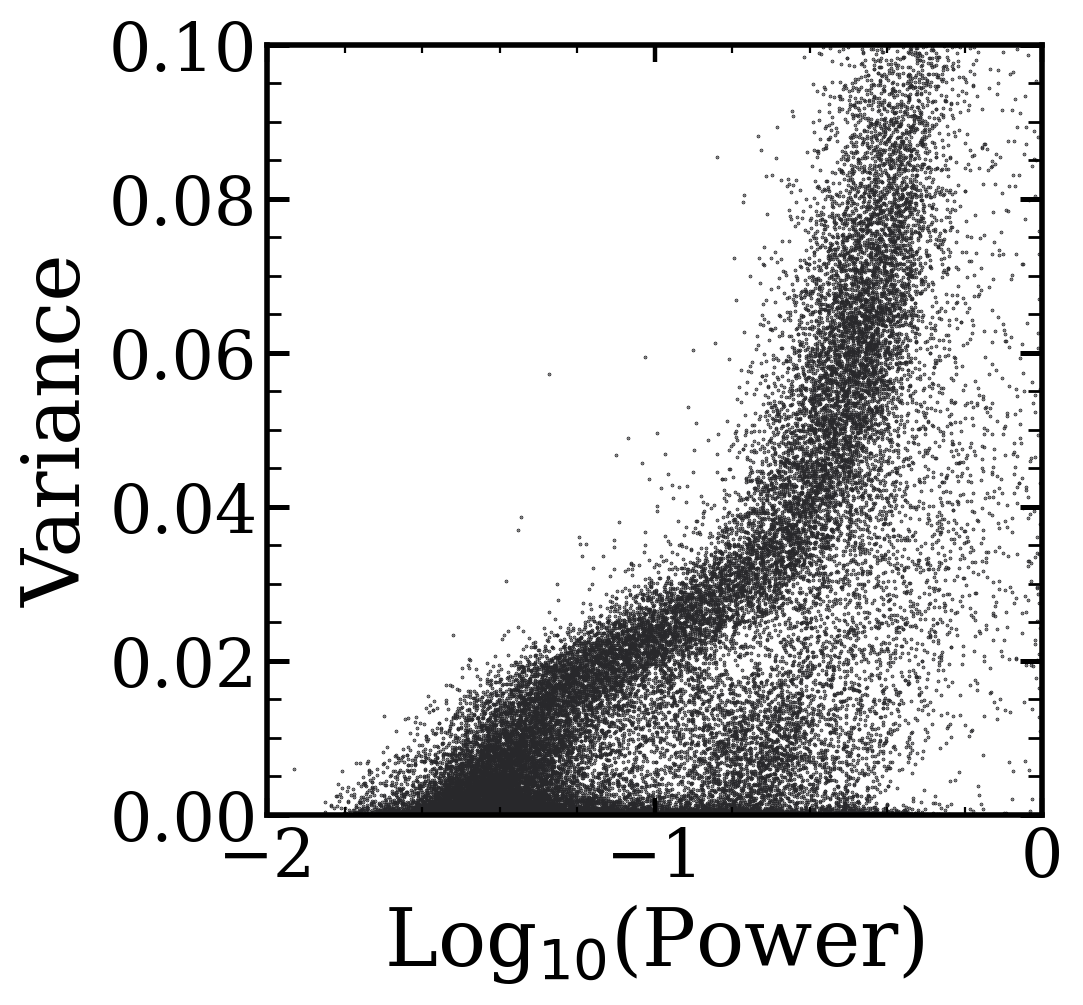

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(table['power']), table['var'], s=0.1, color="#28282B")
plt.ylim(0, 0.1)
plt.xlim(-2, 0)
plt.xlabel("Log$_{10}$(Power)")
plt.ylabel("Variance")
plt.minorticks_on()

## Plot Lightcurve

In [22]:
# TODO: show the most interesting objects

lc_id = 1195681424221405184
lc_data = ens.to_timeseries(lc_id).data
r_filter = lc_data.band_ztf_source=='r'
g_filter = lc_data.band_ztf_source=='g'

KeyError: 'band'

In [ ]:
plt.figure(figsize=(8,4))

plt.errorbar(lc_data.mjd_ztf_source[r_filter], lc_data.mag_ztf_source[r_filter],
              yerr=lc_data.magerr_ztf_source[r_filter], fmt='.', color='indianred', 
              label='ZTF-r')

plt.errorbar(lc_data.mjd_ztf_source[g_filter], lc_data.mag_ztf_source[g_filter], fmt='.',
              yerr=lc_data.magerr_ztf_source[g_filter],
             color='royalblue', 
             label='ZTF-g')

plt.legend(title='Band:')
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude")

NameError: name 'plt' is not defined

In [ ]:
# client.shutdown()